<a href="https://colab.research.google.com/github/areias/viral-escape/blob/main/FluBERTa_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Escape prediction validation

We obtained experimentally validated causal escape mutations to HA H1 WSN33 from Doud et al. (1)

* Make, in silico, all possible single-residue mutations to H1 WSN33
* For each of these mutations, compute semantic change and grammaticality and combine these scores using the CSCS rank-based acquisition function 
* rank all possible mutants usng the value of the CSCS acquisition function 
* to assess enrichment of acquired escape mutants, we constructed a curve that plotted the top n CSCS-acquired mutants on the x-axis and the corresponding number of these mutants that were also causal escape mutations on the y-axis; the area under this curve, normalized to the total possible area, resulted in our normalized AUC metric for evaluating escape enrichment. The AUC is normalized to be between 0 and 1, where a value of 0.5 indicates random guessing and higher values indicate greater enrichment.

## 1. Check GPU and RAM specifications

In [269]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr  6 18:28:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [270]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [271]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# install dependencies
! pip install anndata 

     |████████████████████████████████| 96 kB 3.2 MB/s 


In [5]:
! pip install scanpy

     |████████████████████████████████| 2.0 MB 4.3 MB/s 
     |████████████████████████████████| 11.2 MB 62.9 MB/s 
     |████████████████████████████████| 86 kB 7.3 MB/s 
     |████████████████████████████████| 899 kB 59.2 MB/s 
     |████████████████████████████████| 1.1 MB 64.9 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=2f38b7ee93d77ae0c607ebcdcbf81493eda380d2c7f0cd980c9b3043ea84c364
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=2dd0bf2a565004aa38652953328a2d5cc27a20ac1d43689022e5a03084404275
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8048 sha256=7c8da9c28207f6da1ad12b9d6333

In [6]:
! pip install bio


     |████████████████████████████████| 273 kB 4.2 MB/s 
     |████████████████████████████████| 2.3 MB 66.3 MB/s 


In [7]:
AAs = [
        'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H',
        'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W',
        'Y', 'V', 'X', 'Z', 'J', 'U', 'B', 'Z'
    ]
    
vocabulary = { aa: idx + 1 for idx, aa in enumerate(sorted(AAs)) }



In [8]:
len(vocabulary)

25

## 3. Load RoBERTa model

In [9]:
! pip install transformers

     |████████████████████████████████| 3.8 MB 4.1 MB/s 
     |████████████████████████████████| 77 kB 7.8 MB/s 
     |████████████████████████████████| 596 kB 75.5 MB/s 
     |████████████████████████████████| 6.5 MB 81.2 MB/s 
     |████████████████████████████████| 895 kB 77.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [10]:
! pip install tokenizers

In [11]:
# Check that PyTorch sees it
import torch
torch.cuda.is_available()

True

In [12]:
from transformers import PreTrainedTokenizerFast

fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file="drive/MyDrive/FluBERTa/tokenizer/tokenizer-flu.json",
                                         pad_token='<pad>',
                                         bos_token='<s>',
                                         eos_token='</s>',
                                         mask_token='<mask>',
                                         unk_token='<unk>',
                                         max_len=512,
                                         padding='max_length')


In [13]:
# load model
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM.from_pretrained("drive/MyDrive/FluBERTa/checkpoint-11940")
model.eval()

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(10000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [4]:
import pandas as pd 
import numpy as np

### Original HA H1 WSN33 sequence

In [20]:
# add mutation to path
import sys
sys.path.append('drive/MyDrive/viral-mutation/bin')

from escape import load_doud2018, load_lee2019

seq_to_mutate, escape_seqs = load_doud2018()


In [16]:
seq_to_mutate

Seq('MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI')

In [17]:
len(seq_to_mutate)

565

In [18]:
inputs = fast_tokenizer(str(seq_to_mutate), return_tensors='pt',truncation=True, max_length=512, pad_to_max_length=True)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [19]:
with torch.no_grad():
    preds=model(inputs.input_ids,output_hidden_states=True)
    token_logits = preds.logits
    original_embedding = [x.detach().numpy().mean(axis=0)  for x in preds[1][0]]

In [20]:
original_embedding[0].shape

(768,)

### Compute mutational probabilities of base sequence

In [41]:
len(seq_to_mutate)

565

In [42]:
# completed in 2:58hrs 
from collections import defaultdict
from scipy.spatial.distance import cityblock

for i in range(len(seq_to_mutate)):

    # intialize empty dicts
    seq_prob = defaultdict(dict)
    seq_change = defaultdict(dict)
 
    # mask sequence
    masked_seq=str(seq_to_mutate)[0:i] + fast_tokenizer.mask_token + str(seq_to_mutate)[i+1:]

    # get predicted probabilties 
    inputs = fast_tokenizer(masked_seq, return_tensors='pt',truncation=True, max_length=512, pad_to_max_length=True)
    with torch.no_grad():
        token_logits=model(inputs.input_ids).logits

    # limit to probability of masked token
    mask_token_index = torch.where(inputs.input_ids == fast_tokenizer.mask_token_id)[1]
    logits = token_logits[0, mask_token_index, :].squeeze()
    prob = logits.softmax(dim=0)

    # probability of single mutations
    values, indices = prob.topk(k=1000, dim=0)
    for index, token in enumerate(fast_tokenizer.convert_ids_to_tokens(indices)):
        if len(token)==1:
            seq_prob[masked_seq.replace(fast_tokenizer.mask_token, token)] = values[index].item()


    # get embeddings for mutations
    X_batch=list(seq_prob.keys())
    inputs = fast_tokenizer(X_batch, return_tensors='pt',truncation=True, max_length=512, pad_to_max_length=True)
    with torch.no_grad():
        outputs=model(inputs.input_ids, output_hidden_states=True)
        sequence_embeddings=[x.detach().numpy().mean(axis=0)  for x in outputs[1][0]]

    # get l1 distance from original embedding 
    for index, embedding in enumerate(sequence_embeddings):
        seq_change[X_batch[index]] = cityblock(original_embedding[0],embedding)

    # save to file
    prob_df = pd.DataFrame.from_dict(seq_prob, orient='index').reset_index()
    prob_df.to_csv("drive/MyDrive/FluBERTa/sequence_probabilities.csv", mode='a', header=False, index=False)

    change_df = pd.DataFrame.from_dict(seq_change, orient='index').reset_index()
    change_df.to_csv("drive/MyDrive/FluBERTa/sequence_change.csv", mode='a', header=False, index=False)

    if i%10==0:
        print(i)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560


In [272]:
prob_df = pd.read_csv("drive/MyDrive/FluBERTa/sequence_probabilities.csv", header=None)


In [276]:
prob_df.head()

,0,1
0,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.210636
1,CKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.001616
2,TKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.000836
3,AKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.000670
4,KKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.000650


In [273]:
len(prob_df)

12361

In [274]:
change_df = pd.read_csv("drive/MyDrive/FluBERTa/sequence_change.csv",header=None)
len(change_df)

12361

In [277]:
prob_df.columns=['sequence', 'prob']
change_df.columns=['sequence', 'change']

In [9]:
df=pd.merge(prob_df, change_df, on='sequence', how="left")

In [10]:
df['sequence'][0]==df['sequence'][1]

True

In [11]:
# there are 562 duplicated sequences but they are result of different mutations 
# obviosuly next time keep original letter, mutation, position
df[df['sequence'].duplicated(keep=False)]

,sequence,prob,change
0,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.210636,0.0
1,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.210636,0.0
2,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.210636,0.0
3,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.210636,0.0
4,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.210636,0.0
...,...,...,...
327616,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.002924,0.0
327617,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.002924,0.0
327618,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.002924,0.0
327619,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.002924,0.0


In [280]:
## rank high semantic change and high probability
df['prob_rank']=df['prob'].rank(ascending=False, method='min')
df['change_rank']=df['change'].rank(ascending=True, method='min')
df.to_csv("drive/MyDrive/FluBERTa/mutation-rank.csv", index=False)

<AxesSubplot:xlabel='prob_rank', ylabel='prob'>

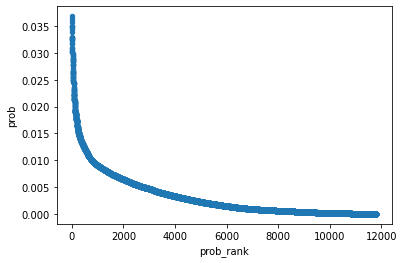

In [281]:
# higher probability higher rank
df.plot.scatter(x='prob_rank', y='prob')

<AxesSubplot:xlabel='change_rank', ylabel='change'>

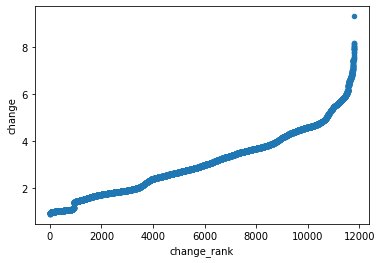

In [282]:
# lower change higher rank
df.plot.scatter(x='change_rank', y='change')

In [246]:
df['overall_rank'] = df['prob_rank'] + df['change_rank']

In [247]:
df.sort_values("overall_rank")

,sequence,prob,change,prob_rank,change_rank,overall_rank,is_escape,is_viable
8170,MKAKLLVLLYAFVAFDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.026519,0.970592,44.0,24.0,68.0,True,False
8171,MKAKLLVLLYAFVAKDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.021038,0.930874,102.0,3.0,105.0,True,False
69297,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.018349,0.977736,154.0,36.0,190.0,True,False
8169,MKAKLLVLLYAFVACDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.028566,1.020291,34.0,216.0,250.0,True,False
8172,MKAKLLVLLYAFVAADADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.020277,1.008058,112.0,145.0,257.0,True,False
...,...,...,...,...,...,...,...,...
311290,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.000002,6.888215,11736.0,11720.0,23456.0,False,NaN
277418,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.000002,7.009833,11740.0,11734.0,23474.0,False,NaN
278002,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.000002,7.047119,11737.0,11740.0,23477.0,False,NaN
273330,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.000002,7.121932,11742.0,11744.0,23486.0,False,NaN


In [284]:
df['overall_rank'].describe()

count    11799.000000
mean     11799.999576
std       5772.132960
min         68.000000
25%       6918.000000
50%      11364.000000
75%      16785.000000
max      23519.000000
Name: overall_rank, dtype: float64

In [283]:
df=df[df['change']>0]

In [250]:
topk=df.nsmallest(10, 'overall_rank')
topk


,sequence,prob,change,prob_rank,change_rank,overall_rank,is_escape,is_viable
8170,MKAKLLVLLYAFVAFDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.026519,0.970592,44.0,24.0,68.0,True,False
8171,MKAKLLVLLYAFVAKDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.021038,0.930874,102.0,3.0,105.0,True,False
69297,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.018349,0.977736,154.0,36.0,190.0,True,False
8169,MKAKLLVLLYAFVACDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.028566,1.020291,34.0,216.0,250.0,True,False
8172,MKAKLLVLLYAFVAADADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.020277,1.008058,112.0,145.0,257.0,True,False
23884,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVLVTHS...,0.016607,0.989565,207.0,63.0,270.0,True,False
2311,MKAILLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.014756,0.986703,279.0,56.0,335.0,True,False
3503,MKAKLLILLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.013185,0.938504,401.0,6.0,407.0,True,False
7007,MKAKLLVLLYAFIATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.015809,1.016794,232.0,185.0,417.0,True,False
24467,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVALTHS...,0.014559,1.011643,288.0,159.0,447.0,True,False


In [251]:
df['is_escape'] = np.nan
df['is_viable'] = np.nan

In [252]:
for row in df.iterrows():
    #print(df.loc[row[0],"sequence"])
    if row[1]['sequence'] in escape_seqs:
        df.loc[row[0], 'is_escape'] = True
        df.loc[row[0], 'is_viable'] = sum([ m['significant']for m in escape_seqs[row[1]['sequence'] ] ]) > 0
    else:
        df.loc[row[0], 'is_escape'] = False


In [253]:
df['is_escape'].value_counts()

True     10679
False     1120
Name: is_escape, dtype: int64

In [254]:
df['is_viable'].value_counts()

False    10509
True       170
Name: is_viable, dtype: int64

In [255]:
filtered=df.loc[df['is_escape']==True]

In [256]:
filtered.head()

,sequence,prob,change,prob_rank,change_rank,overall_rank,is_escape,is_viable
562,CKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.001616,4.041759,5790.0,8878.0,14668.0,True,False
563,TKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.000836,2.813788,7250.0,5470.0,12720.0,True,False
564,AKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.000670,2.920809,7833.0,5822.0,13655.0,True,False
565,KKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.000650,2.830333,7902.0,5531.0,13433.0,True,False
566,IKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.000564,2.833244,8205.0,5543.0,13748.0,True,False


In [257]:
len(filtered.nsmallest(100, 'overall_rank')['is_viable'].value_counts())

2

In [259]:
x=[]
y=[]
for i in range(100,len(filtered),100):
    x.append(i)
    if len(filtered.nsmallest(i, 'overall_rank')['is_viable'].value_counts()) >1:
        y.append(filtered.nsmallest(i, 'overall_rank')['is_viable'].value_counts()[1])
    else:
        y.append(0)


In [260]:
import matplotlib.pyplot as plt

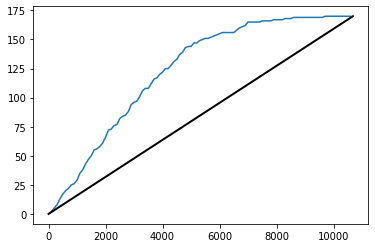

In [261]:
plt.plot(x,y)
plt.plot([0, 10679], [0, 170], color = 'black', linewidth = 2)

In [262]:
from sklearn.metrics import auc
auc(x,y)

1302300.0

In [263]:
auc(x,y)/(10679*170)

0.7173507103000392

In [264]:
filtered['change'].describe()

count    10679.000000
mean         3.041217
std          1.356107
min          0.912777
25%          1.875845
50%          2.866066
75%          3.890992
max          9.290375
Name: change, dtype: float64

In [265]:
filtered.head()

,sequence,prob,change,prob_rank,change_rank,overall_rank,is_escape,is_viable
562,CKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.001616,4.041759,5790.0,8878.0,14668.0,True,False
563,TKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.000836,2.813788,7250.0,5470.0,12720.0,True,False
564,AKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.000670,2.920809,7833.0,5822.0,13655.0,True,False
565,KKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.000650,2.830333,7902.0,5531.0,13433.0,True,False
566,IKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.000564,2.833244,8205.0,5543.0,13748.0,True,False


In [266]:

filtered.loc[:,'log_prob']= np.log10(filtered['prob'])
filtered.loc[:,'log_change']= np.log10(filtered['change'])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [267]:
viable=filtered.loc[filtered['is_viable']==True]

<AxesSubplot:xlabel='log_prob', ylabel='log_change'>

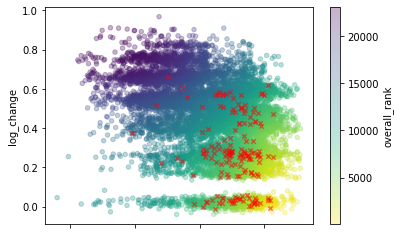

In [268]:
#fig= plt.figure(figsize=(10,15))
ax = filtered.plot(kind='scatter',x='log_prob', y='log_change', c='overall_rank', colormap='viridis_r',alpha = 0.3)
viable.plot(kind='scatter',x='log_prob', y='log_change', c='red',alpha = 0.5, marker='x', ax=ax)
#fig.show()


<AxesSubplot:xlabel='prob', ylabel='log_prob'>

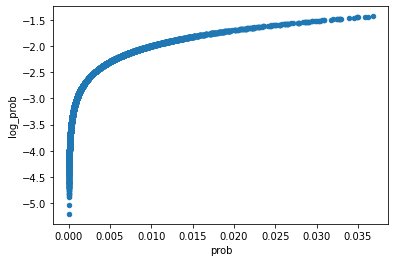

In [203]:
filtered.plot.scatter("prob",'log_prob')

<AxesSubplot:xlabel='change', ylabel='log_change'>

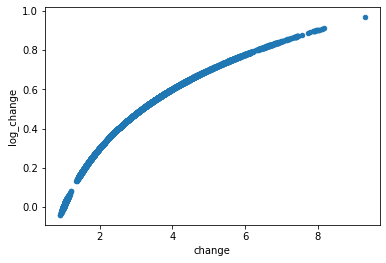

In [204]:
filtered.plot.scatter("change",'log_change')